# DDPG for Pendulum env

## import required libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import random
%matplotlib inline

## Setting of Hyper parameters

In [2]:
lr = 1e-3 #learning rate
tau = 0.001 #soft update rate
gamma = 0.99 # TD target decaying factor
buffer_size = 20000 #length of Replay Buffer
batch_size = 64 #mini batch size
n_episode = 300 #epcoh

noise_eps = 1 #hyper parameters for OUNoise
noise_eps_decay = 0.001
noise_eps_min = 0.001

## Replay Buffer

In [3]:
class ReplayBuffer:
    def __init__(self, buffer_size, random_seed = 777):
        self.buffer_size = buffer_size
        self.random_seed = random_seed
        random.seed(self.random_seed)
        self.buffer = []
    
    def add(self,s,a,r,t,s2):
        experience = (s,a,r,t,s2) #s :(3,) a:(1,) r: scalar, t : boolean
        if len(self.buffer) < self.buffer_size:
            self.buffer.append(experience)
        else:
            self.buffer.pop(0)
            self.buffer.append(experience)
            
    def batch_sample(self, batch_size):
        if len(self.buffer) <= batch_size:
            batch_list = random.sample(self.buffer, len(self.buffer))
        else:
            batch_list = random.sample(self.buffer, batch_size)
            
        s_b = np.array([e[0] for e in batch_list]) #(batch_size, 3)
        a_b = np.array([e[1] for e in batch_list]) #(batch_size, 1)
        r_b = np.array([e[2] for e in batch_list]) #(batch_size, )
        t_b = np.array([e[3] for e in batch_list]) #(batch_size, )
        s2_b = np.array([e[4] for e in batch_list]) #(batch_size, 3)
        
        return s_b, a_b, r_b, t_b, s2_b

    def clear(self):
        self.buffer = []

## OU Noise
### 𝑵_𝒕=𝑵_(𝒕−𝟏)+𝜽(𝝁−𝑵_(𝒕−𝟏) )+ 𝝈𝒓,  𝒓~𝑵𝒐𝒓𝒎𝒂𝒍(𝟎,𝟏)

In [4]:
class OUNoise:
    
    def __init__(self, a_dim, mean = 0, theta = 0.15, sigma = 0.2):
        self.a_dim = a_dim
        self.mean = mean
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.a_dim) * self.mean
        
    def reset(self):
        self.state = np.ones(self.a_dim) * self.mean
        
    def noise(self):
        x = self.state
        dx = self.theta * (self.mean - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

## Critic Class
### Input : state and action /output : action_value

In [5]:
class Critic(nn.Module):
    
    def __init__(self, n_states, n_actions):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(n_states + n_actions , 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 128)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(128, 32)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(32, 1)
        self.fc4.weight.data.normal_(0, 0.1)
        self.relu = nn.ReLU()
        
    def forward(self, state, action):
        x = torch.cat((state, action), dim = 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        value = self.fc4(x)
        return value

## Actor Class
### Input : state / output : action

In [6]:
class Actor(nn.Module):
    
    def __init__(self, n_states, n_actions, action_lim):
        super(Actor, self).__init__()
        self.action_lim = action_lim
        self.fc1 = nn.Linear(n_states, 64)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(64, 128)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(128, 32)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(32, n_actions)
        self.fc4.weight.data.uniform_(-action_lim, action_lim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        action = self.tanh(self.fc4(x)) * self.action_lim
        return action
    

## DDPG Class
### train phase summary
sample mini batch from Replay Buffer, and convert them to tensor              
Calculate TD target by actor_target and critic_target                
Update Critic Loss by MSE                  
Update Actor Loss by Current action value                  
Soft update target network with hyper parameter tau              

In [25]:
class DDPG:
    def __init__(self, n_states, n_actions, action_lim, buffer_size, device, train = True):
        self.device = device
        
        self.actor = Actor(n_states, n_actions, action_lim).to(device)
        self.critic = Critic(n_states, n_actions).to(device)
        self.actor_target = Actor(n_states, n_actions, action_lim).to(device)
        self.critic_target = Critic(n_states, n_actions).to(device)
        self.actor_optimizer = torch.optim.SGD(self.actor.parameters(), lr = lr)
        self.critic_optimizer = torch.optim.SGD(self.critic.parameters(), lr = lr)
       
        self.noise_eps = noise_eps #hyper parameters for OUNoise
        self.noise_eps_decay = noise_eps_decay
        self.noise_eps_min = noise_eps_min
        
        self.buffer = ReplayBuffer(buffer_size)
        
        self.ounoise = OUNoise(n_actions)
        
        self.is_training = train
        
        self.hard_update()
        
    def select_action(self, state):
        self.noise_eps -= self.noise_eps_decay
        
        state_tensor = torch.FloatTensor(state).to(device)
        raw_action = self.actor(state_tensor).detach().cpu().numpy()
        raw_action += self.is_training * max(self.noise_eps, self.noise_eps_min) * self.ounoise.noise()
        
        action_bound = self.actor.action_lim
        action = np.clip(raw_action, -action_bound, action_bound)
        return action #(1,)
    
    def sample_tensor(self, batch_size):
        s_b, a_b, r_b, t_b, s2_b = self.buffer.batch_sample(batch_size)
        
        s_b = torch.FloatTensor(s_b).to(self.device)
        a_b = torch.FloatTensor(a_b).to(self.device)
        r_b = torch.FloatTensor(r_b).to(self.device)
        t_b = torch.FloatTensor(t_b==False).to(self.device)
        s2_b = torch.FloatTensor(s2_b).to(self.device)
        
        return s_b, a_b, r_b, t_b, s2_b
    
    def train(self, batch_size):
        s_b, a_b, r_b, t_b, s2_b = self.sample_tensor(batch_size)
        
        #To compute TD Target
        a2_b = self.actor_target(s2_b).detach()
        
        #TD Target and current prediction
        target_Q = r_b.unsqueeze(1) + t_b.unsqueeze(1) * self.critic_target(s2_b, a2_b).detach() * gamma
        pred_Q = self.critic(s_b,a_b)
        
        #critic update
        critic_loss_func = nn.MSELoss()
        critic_loss = critic_loss_func(pred_Q, target_Q)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        #actor update
        action_pred = self.actor(s_b)
        actor_loss = (-self.critic(s_b, action_pred)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        self.soft_update(tau)
        
        return critic_loss.item(), actor_loss.item()
    
    def hard_update(self):
        for target_param, current_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(current_param.data)
        for target_param, current_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(current_param.data)
    
    def soft_update(self, tau):
        for target_param, current_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * current_param.data + (1-tau)*target_param.data)
        for target_param, current_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * current_param.data + (1-tau)*target_param.data)
        

In [28]:
env = gym.make('Pendulum-v0')
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
action_lim = env.action_space.high[0]
device = torch.device("cuda")

agent = DDPG(n_states, n_actions, action_lim, buffer_size, device)

rewards_arr = []
actor_loss_arr = []
critic_loss_arr = []

max_step = 1000
total_step = 0

for e in range(1, n_episode + 1):
    s0 = env.reset()
    agent.ounoise.reset()
    
    done = False
    step = 0
    
    actor_loss, critic_loss, reward = 0, 0, 0
    
    while not done:
        env.render()
        action = agent.select_action(s0)
        s1, r1, done, info = env.step(action)
        agent.buffer.add(s0, action, r1, done, s1)
        s0 = s1
        
        if len(agent.buffer.buffer) > batch_size:
            loss_c, loss_a = agent.train(128)
            actor_loss += loss_a
            critic_loss += loss_c
        
        reward += r1
        step += 1
        total_step += 1
        
        if step >= max_step:
            break
    
    rewards_arr.append(reward)
    actor_loss_arr.append(actor_loss)
    critic_loss_arr.append(critic_loss)
    
    avg_reward = float(np.mean(rewards_arr[-100:]))
    
    print('total step : %5d | episode %3d | ep step %3d | ep reward :%.4f'%(total_step, e, step, reward))
env.close()

total step :   200 | episode   1 | ep step 200 | ep reward :-1378.5868
total step :   400 | episode   2 | ep step 200 | ep reward :-1037.0732
total step :   600 | episode   3 | ep step 200 | ep reward :-1264.3228
total step :   800 | episode   4 | ep step 200 | ep reward :-1297.6717
total step :  1000 | episode   5 | ep step 200 | ep reward :-1358.7349
total step :  1200 | episode   6 | ep step 200 | ep reward :-1513.5512
total step :  1400 | episode   7 | ep step 200 | ep reward :-1204.5424
total step :  1600 | episode   8 | ep step 200 | ep reward :-1183.1194
total step :  1800 | episode   9 | ep step 200 | ep reward :-1504.7229
total step :  2000 | episode  10 | ep step 200 | ep reward :-1432.0342
total step :  2200 | episode  11 | ep step 200 | ep reward :-1194.5021
total step :  2400 | episode  12 | ep step 200 | ep reward :-1519.1398
total step :  2600 | episode  13 | ep step 200 | ep reward :-1565.3121
total step :  2800 | episode  14 | ep step 200 | ep reward :-1545.8978
total 

total step : 23400 | episode 117 | ep step 200 | ep reward :-400.2776
total step : 23600 | episode 118 | ep step 200 | ep reward :-355.0588
total step : 23800 | episode 119 | ep step 200 | ep reward :-897.3313
total step : 24000 | episode 120 | ep step 200 | ep reward :-134.5871
total step : 24200 | episode 121 | ep step 200 | ep reward :-849.0720
total step : 24400 | episode 122 | ep step 200 | ep reward :-119.6075
total step : 24600 | episode 123 | ep step 200 | ep reward :-132.2120
total step : 24800 | episode 124 | ep step 200 | ep reward :-125.2365
total step : 25000 | episode 125 | ep step 200 | ep reward :-129.7395
total step : 25200 | episode 126 | ep step 200 | ep reward :-249.0392
total step : 25400 | episode 127 | ep step 200 | ep reward :-2.2983
total step : 25600 | episode 128 | ep step 200 | ep reward :-234.2698
total step : 25800 | episode 129 | ep step 200 | ep reward :-126.6714
total step : 26000 | episode 130 | ep step 200 | ep reward :-0.4544
total step : 26200 | epi

total step : 47000 | episode 235 | ep step 200 | ep reward :-264.9841
total step : 47200 | episode 236 | ep step 200 | ep reward :-502.4728
total step : 47400 | episode 237 | ep step 200 | ep reward :-383.2905
total step : 47600 | episode 238 | ep step 200 | ep reward :-257.6537
total step : 47800 | episode 239 | ep step 200 | ep reward :-264.9092
total step : 48000 | episode 240 | ep step 200 | ep reward :-259.8382
total step : 48200 | episode 241 | ep step 200 | ep reward :-486.6795
total step : 48400 | episode 242 | ep step 200 | ep reward :-375.9768
total step : 48600 | episode 243 | ep step 200 | ep reward :-478.0497
total step : 48800 | episode 244 | ep step 200 | ep reward :-379.4689
total step : 49000 | episode 245 | ep step 200 | ep reward :-16.9358
total step : 49200 | episode 246 | ep step 200 | ep reward :-261.7043
total step : 49400 | episode 247 | ep step 200 | ep reward :-141.4928
total step : 49600 | episode 248 | ep step 200 | ep reward :-146.1834
total step : 49800 | 

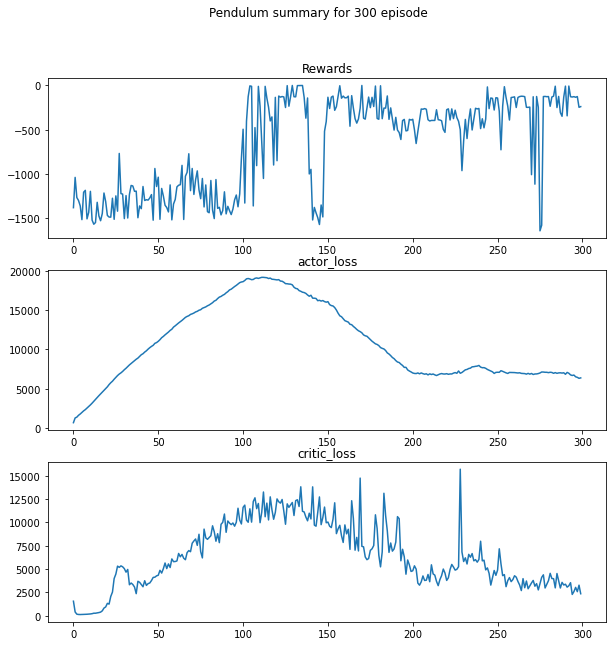

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(10,10))

fig.suptitle('Pendulum summary for 300 episode')
axs[0].set_title('Rewards')
axs[0].plot(np.arange(300), rewards_arr)
axs[1].set_title('actor_loss')
axs[1].plot(np.arange(300), actor_loss_arr)
axs[2].set_title('critic_loss')
axs[2].plot(np.arange(300), critic_loss_arr)